In [1]:
#Plots for paper

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import astropy
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib
import glob

import time
import sys
import os
import pandas as pd

import astropy.units as u
from astropy.coordinates import Angle, SkyCoord, AltAz, EarthLocation
from astropy.time import Time
from astropy.coordinates import Angle

from scipy import interpolate

import galsim
from scipy import ndimage

# location of CTIO
earth_location = EarthLocation.of_site('ctio')

print(earth_location)

(1814303.74553723, -5214365.7436216, -3187340.56598756) m


In [3]:
from scipy.interpolate import interp1d
from scipy.integrate import trapz

In [4]:
dir_strs = ['JL_DCR_DES_v1003/', 'JASON_DCR_ASTROZ_COADD_REALISTIC_v1113/']
t_heads, t_phots, t_DCRs, t_DUMPs = [], [], [], []
for d in range(len(dir_strs)):
    SIM_dir_str = '/pscratch/sd/a/astjason/DCR_AstroZ/' + dir_strs[d]
    t_heads.append(Table.read(glob.glob(SIM_dir_str + '*HEAD.FITS*')[0]))
    t_phots.append(Table.read(glob.glob(SIM_dir_str + '*PHOT.FITS*')[0]))
    t_DCRs.append(pd.read_csv(glob.glob(SIM_dir_str + '*.DCR*')[0], delim_whitespace=True, skiprows = 6))
    t_DUMPs.append(pd.read_csv(glob.glob(SIM_dir_str + '*.DUMP*')[0], delim_whitespace=True, skiprows = 5))

In [5]:
len(np.where(t_DCRs[1]['AIRMASS'].values > 1.4)[0])/len(t_DCRs[1]['AIRMASS'].values)

0.22822690563833437

In [6]:
# R \approx R_0 tan(z_a)
# R_0 = \frac{n^2 - 1}{2n^2}
# R_shift = \frac{int dlambda R(lambda, z_a) F(lambda) S(lambda)}{int dlambda F(lambda) S(lambda)}

def DCR_shift(z_a, filt, source, pressure=77.54, temperature=279.95, H2O_pressure=0.133322):
    wavelengths, filt_response = filt.transpose()[0], filt.transpose()[1]
    spacing = wavelengths[1] - wavelengths[0]
    f_source = interp1d(source.transpose()[0], source.transpose()[1], fill_value = 'extrapolate')
    n = galsim.dcr.air_refractive_index_minus_one(wavelengths/10, pressure=pressure, temperature=temperature, H2O_pressure=H2O_pressure) + 1
    R0 = (n**2 - 1)/(2*n**2)
    R = R0 * np.tan(z_a)
    num, denom = trapz(R*filt_response*f_source(wavelengths), dx = spacing), trapz(filt_response*f_source(wavelengths), dx = spacing)
    return num/denom

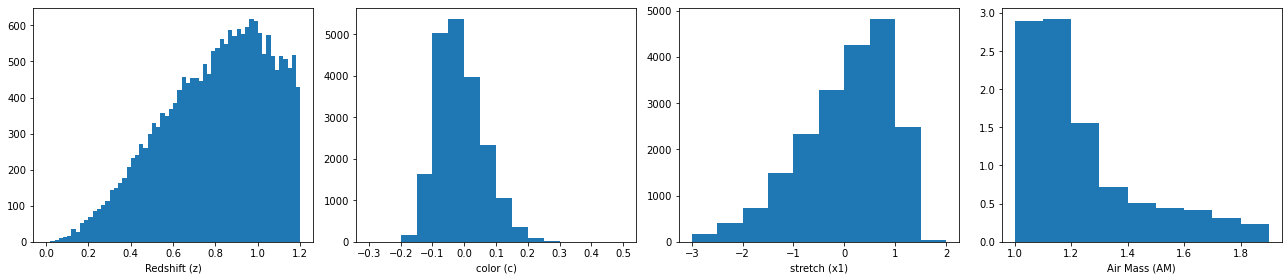

In [7]:
z_range = np.arange(0.00, 1.22, 0.02)
x1_vals, x1_vals_bins = np.arange(-3.0, 2.5, 0.5), np.arange(-3.0, 3.0, 0.5) - 0.5/2
c_vals, c_vals_bins = np.arange(-0.3, 0.55, 0.05), np.arange(-0.3, 0.60, 0.05) - 0.05/2

plt.subplots(1, 4, figsize = [18, 4])

plt.subplot(1, 4, 1)
plt.hist(t_heads[1]['REDSHIFT_FINAL'], bins = z_range);
plt.xlabel('Redshift (z)')

plt.subplot(1, 4, 2)
plt.hist(t_heads[1]['SIM_SALT2c'], bins = c_vals)
plt.xlabel('color (c)')

plt.subplot(1, 4, 3)
plt.hist(t_heads[1]['SIM_SALT2x1'], bins = x1_vals)
plt.xlabel('stretch (x1)')

plt.subplot(1, 4, 4)
plt.hist(t_DCRs[1]['AIRMASS'].values, density = True, bins = np.arange(1.0, 2.0, 0.1))
plt.xlabel('Air Mass (AM)')

plt.tight_layout()

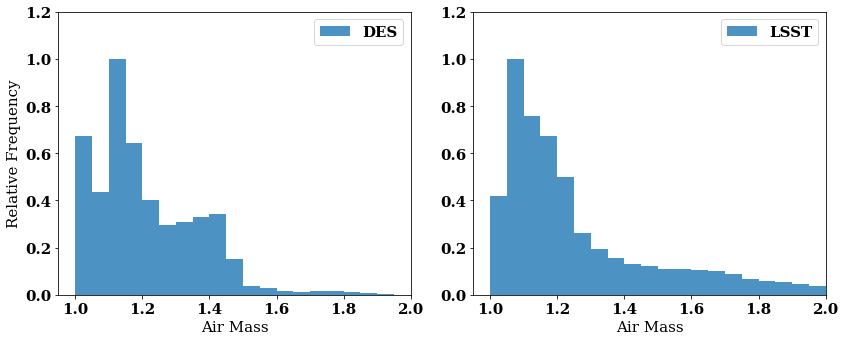

In [8]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

plt.subplots(1, 2, figsize = [12, 5])

#plt.supylabel('Relative Frequency')
nbins = 25

survey_strs = ['DES', 'LSST']

for d in range(len(dir_strs)):
    plt.subplot(1, 2, d+1)
    bin_edges = np.histogram(t_DCRs[d]['AIRMASS'], bins = np.arange(1.0, 2.05, 0.05))[1]
    hist = np.histogram(t_DCRs[d]['AIRMASS'], bins = bin_edges)[0]
    plt.bar(bin_edges[:-1], hist/np.max(hist), width = np.diff(bin_edges), align='edge', label = survey_strs[d], alpha = 0.8)
    #plt.axvline(np.mean(t_DCRs[d]['AIRMASS']), ls = '-', lw = 3, color = 'blue', label = 'Mean: %.3f' %np.mean(t_DCRs[d]['AIRMASS']))
    #plt.axvline(np.median(t_DCRs[d]['AIRMASS']), ls = '--', lw = 3, color = 'k', label = 'Median: %.3f' %np.median(t_DCRs[d]['AIRMASS']))
    plt.legend()
    plt.xlabel('Air Mass')
    #plt.xticks(np.linspace(1.0, 2.0, num = 6))
    if d == 0:
        plt.ylabel('Relative Frequency')
    #if d != 3:
    #    plt.xticks([])
    plt.ylim(0.00, 1.2)
    plt.xlim(0.95, 2.0)
plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()
plt.savefig('DCR_AstroZ/results/Plots_for_Paper/AM_by_survey.png', dpi = 100)

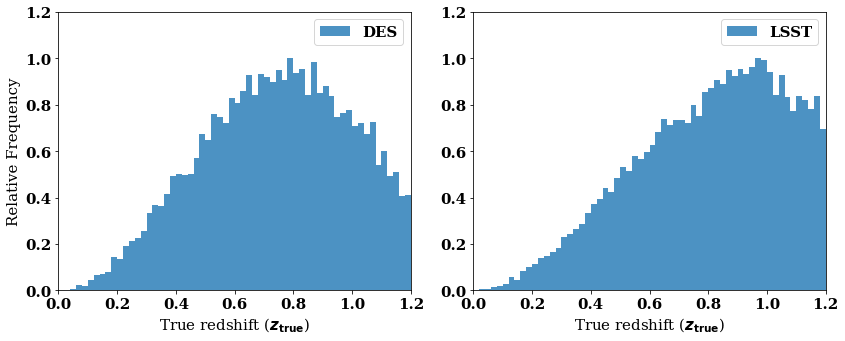

In [9]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

plt.subplots(1, 2, figsize = [12, 5])

#plt.supylabel('Relative Frequency')
nbins = 25

survey_strs = ['DES', 'LSST']

for d in range(len(dir_strs)):
    plt.subplot(1, 2, d+1)
    bin_edges = np.histogram(t_heads[d]['REDSHIFT_FINAL'], bins = np.arange(0.0, 1.22, 0.02))[1]
    hist = np.histogram(t_heads[d]['REDSHIFT_FINAL'], bins = bin_edges)[0]
    plt.bar(bin_edges[:-1], hist/np.max(hist), width = np.diff(bin_edges), align='edge', label = survey_strs[d], alpha = 0.8)
    #plt.axvline(np.mean(t_DCRs[d]['AIRMASS']), ls = '-', lw = 3, color = 'blue', label = 'Mean: %.3f' %np.mean(t_DCRs[d]['AIRMASS']))
    #plt.axvline(np.median(t_DCRs[d]['AIRMASS']), ls = '--', lw = 3, color = 'k', label = 'Median: %.3f' %np.median(t_DCRs[d]['AIRMASS']))
    plt.legend()
    plt.xlabel(r'True redshift ($z_{\mathrm{true}}$)')
    #plt.xticks(np.linspace(1.0, 2.0, num = 6))
    if d == 0:
        plt.ylabel('Relative Frequency')
    #if d != 3:
    #    plt.xticks([])
    plt.ylim(0.00, 1.2)
    plt.xlim(0.00, 1.2)
plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()
plt.savefig('DCR_AstroZ/results/Plots_for_Paper/redshifts_by_survey.png', dpi = 100)

In [10]:
where_epoch_condition, where_epoch_and_SNR, where_epoch_and_SNR_and_AM = np.load('DCR_AstroZ/' + dir_strs[1] + 'where_conditions.npy', allow_pickle=True)

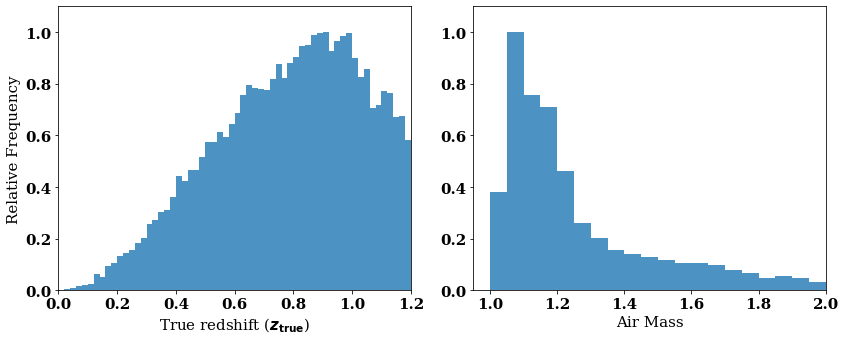

In [11]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

plt.subplots(1, 2, figsize = [12, 5])

#plt.supylabel('Relative Frequency')

#quant_strs = ['', 'LSST']

plt.subplot(1, 2, 1)
bin_edges = np.histogram(t_heads[1]['REDSHIFT_FINAL'][where_epoch_condition], bins = np.arange(0.0, 1.22, 0.02))[1]
hist = np.histogram(t_heads[1]['REDSHIFT_FINAL'][where_epoch_condition], bins = bin_edges)[0]
plt.bar(bin_edges[:-1], hist/np.max(hist), width = np.diff(bin_edges), align='edge', alpha = 0.8)
plt.xlabel(r'True redshift ($z_{\mathrm{true}}$)')
plt.ylabel('Relative Frequency')
plt.ylim(0.00, 1.1)
plt.xlim(0.00, 1.2)
plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()

plt.subplot(1, 2, 2)
bin_edges = np.histogram(t_DCRs[d]['AIRMASS'][where_epoch_condition], bins = np.arange(1.0, 2.05, 0.05))[1]
hist = np.histogram(t_DCRs[d]['AIRMASS'][where_epoch_condition], bins = bin_edges)[0]
plt.bar(bin_edges[:-1], hist/np.max(hist), width = np.diff(bin_edges), align='edge', label = survey_strs[d], alpha = 0.8)
plt.xlabel('Air Mass')
plt.ylim(0.00, 1.1)
plt.xlim(0.95, 2.0)
plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()
plt.savefig('DCR_AstroZ/results/Plots_for_Paper/redshift_and_AM_LSST_epoch_condition.png', dpi = 100)

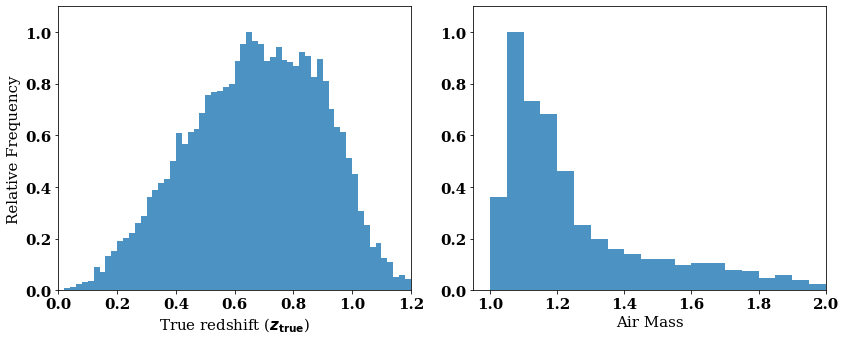

In [12]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

plt.subplots(1, 2, figsize = [12, 5])

#plt.supylabel('Relative Frequency')

#quant_strs = ['', 'LSST']

plt.subplot(1, 2, 1)
bin_edges = np.histogram(t_heads[1]['REDSHIFT_FINAL'][where_epoch_and_SNR], bins = np.arange(0.0, 1.22, 0.02))[1]
hist = np.histogram(t_heads[1]['REDSHIFT_FINAL'][where_epoch_and_SNR], bins = bin_edges)[0]
plt.bar(bin_edges[:-1], hist/np.max(hist), width = np.diff(bin_edges), align='edge', alpha = 0.8)
plt.xlabel(r'True redshift ($z_{\mathrm{true}}$)')
plt.ylabel('Relative Frequency')
plt.ylim(0.00, 1.1)
plt.xlim(0.00, 1.2)
plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()

plt.subplot(1, 2, 2)
bin_edges = np.histogram(t_DCRs[d]['AIRMASS'][where_epoch_and_SNR], bins = np.arange(1.0, 2.05, 0.05))[1]
hist = np.histogram(t_DCRs[d]['AIRMASS'][where_epoch_and_SNR], bins = bin_edges)[0]
plt.bar(bin_edges[:-1], hist/np.max(hist), width = np.diff(bin_edges), align='edge', label = survey_strs[d], alpha = 0.8)
plt.xlabel('Air Mass')
plt.ylim(0.00, 1.1)
plt.xlim(0.95, 2.0)
plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()
plt.savefig('DCR_AstroZ/results/Plots_for_Paper/redshift_and_AM_LSST_epoch_and_SNR.png', dpi = 100)

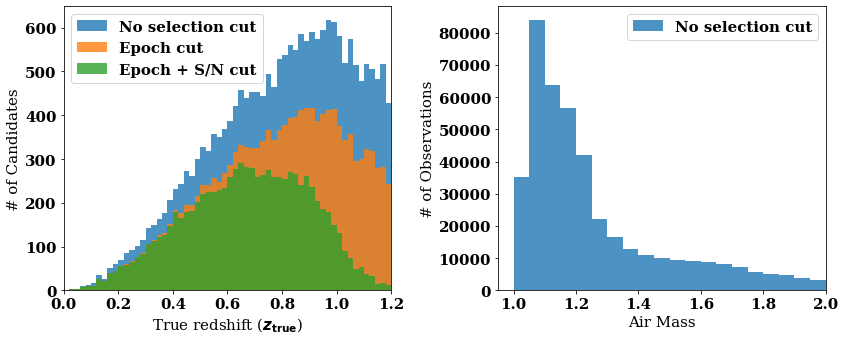

In [13]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

plt.subplots(1, 2, figsize = [12, 5])

#plt.supylabel('Relative Frequency')

#quant_strs = ['', 'LSST']
selection_cut_str = ['No selection cut', 'Epoch cut', 'Epoch + S/N cut']

plt.subplot(1, 2, 1)
bin_edges = np.histogram(t_heads[1]['REDSHIFT_FINAL'], bins = np.arange(0.0, 1.22, 0.02))[1]
hist = np.histogram(t_heads[1]['REDSHIFT_FINAL'], bins = bin_edges)[0]
plt.bar(bin_edges[:-1], hist, width = np.diff(bin_edges), align='edge', label = selection_cut_str[0], alpha = 0.8)
bin_edges = np.histogram(t_heads[1]['REDSHIFT_FINAL'][where_epoch_condition], bins = np.arange(0.0, 1.22, 0.02))[1]
hist = np.histogram(t_heads[1]['REDSHIFT_FINAL'][where_epoch_condition], bins = bin_edges)[0]
plt.bar(bin_edges[:-1], hist, width = np.diff(bin_edges), align='edge', label = selection_cut_str[1], alpha = 0.8)
bin_edges = np.histogram(t_heads[1]['REDSHIFT_FINAL'][where_epoch_and_SNR], bins = np.arange(0.0, 1.22, 0.02))[1]
hist = np.histogram(t_heads[1]['REDSHIFT_FINAL'][where_epoch_and_SNR], bins = bin_edges)[0]
plt.bar(bin_edges[:-1], hist, width = np.diff(bin_edges), align='edge', label = selection_cut_str[2], alpha = 0.8)
plt.xlabel(r'True redshift ($z_{\mathrm{true}}$)')
plt.ylabel('# of Candidates')
#plt.ylim(0.00, 1.1)
plt.xlim(0.00, 1.2)
plt.legend()
plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()

plt.subplot(1, 2, 2)
bin_edges = np.histogram(t_DCRs[d]['AIRMASS'], bins = np.arange(1.0, 2.05, 0.05))[1]
hist = np.histogram(t_DCRs[d]['AIRMASS'], bins = bin_edges)[0]
plt.bar(bin_edges[:-1], hist, width = np.diff(bin_edges), align='edge', label = selection_cut_str[0], alpha = 0.8)
plt.legend()
#bin_edges = np.histogram(t_DCRs[d]['AIRMASS'][where_epoch_condition], bins = np.arange(1.0, 2.05, 0.05))[1]
#hist = np.histogram(t_DCRs[d]['AIRMASS'][where_epoch_condition], bins = bin_edges)[0]
#plt.bar(bin_edges[:-1], hist, width = np.diff(bin_edges), align='edge', label = survey_strs[d], alpha = 0.8)
#bin_edges = np.histogram(t_DCRs[d]['AIRMASS'][where_epoch_and_SNR], bins = np.arange(1.0, 2.05, 0.05))[1]
#hist = np.histogram(t_DCRs[d]['AIRMASS'][where_epoch_and_SNR], bins = bin_edges)[0]
#plt.bar(bin_edges[:-1], hist, width = np.diff(bin_edges), align='edge', label = survey_strs[d], alpha = 0.8)

#Not showing other cuts for AM because AM is independent + there are 30 ~ 40 AM values per SN

plt.xlabel('Air Mass')
plt.ylabel('# of Observations')

#plt.ylim(0.00, 1.1)
plt.xlim(0.95, 2.0)
plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()
plt.savefig('DCR_AstroZ/results/Plots_for_Paper/redshift_and_AM_LSST_all_selection_cuts.png', dpi = 100)

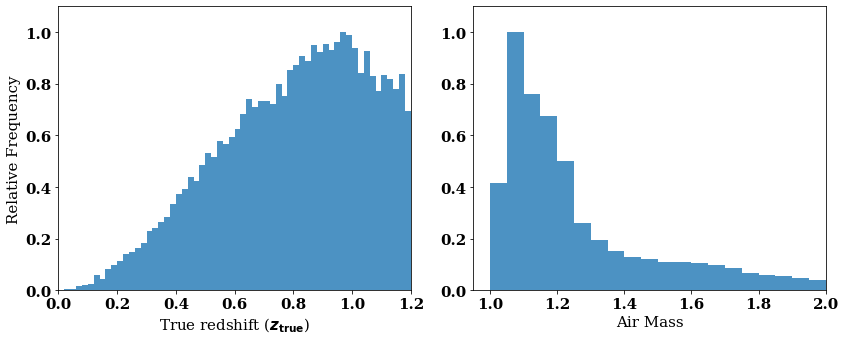

In [14]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

plt.subplots(1, 2, figsize = [12, 5])

#plt.supylabel('Relative Frequency')

#quant_strs = ['', 'LSST']

plt.subplot(1, 2, 1)
bin_edges = np.histogram(t_heads[1]['REDSHIFT_FINAL'], bins = np.arange(0.0, 1.22, 0.02))[1]
hist = np.histogram(t_heads[1]['REDSHIFT_FINAL'], bins = bin_edges)[0]
plt.bar(bin_edges[:-1], hist/np.max(hist), width = np.diff(bin_edges), align='edge', alpha = 0.8)
plt.xlabel(r'True redshift ($z_{\mathrm{true}}$)')
plt.ylabel('Relative Frequency')
plt.ylim(0.00, 1.1)
plt.xlim(0.00, 1.2)
plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()

plt.subplot(1, 2, 2)
bin_edges = np.histogram(t_DCRs[d]['AIRMASS'], bins = np.arange(1.0, 2.05, 0.05))[1]
hist = np.histogram(t_DCRs[d]['AIRMASS'], bins = bin_edges)[0]
plt.bar(bin_edges[:-1], hist/np.max(hist), width = np.diff(bin_edges), align='edge', label = survey_strs[d], alpha = 0.8)
plt.xlabel('Air Mass')
plt.ylim(0.00, 1.1)
plt.xlim(0.95, 2.0)
plt.subplots_adjust(hspace = 0.) 
plt.tight_layout()
plt.savefig('DCR_AstroZ/results/Plots_for_Paper/redshift_and_AM_LSST.png', dpi = 100)

In [15]:
ref_star_SED = np.loadtxt('/global/cfs/cdirs/des/jlee/SN_Ia/star_SEDs/ukk5v.dat')

#f_source = interp1d(ref_star_SED.transpose()[0], ref_star_SED.transpose()[1])


LSST_bands = ['u', 'g', 'r', 'i', 'z']
DES_bands = ['g', 'r', 'i', 'z']

LSST_band_colors = ['blue', 'green', 'red', 'orange', 'violet']
DES_band_colors = ['green', 'red', 'orange', 'violet']

SNANA_lsst_bands, SNANA_des_bands = [], []
for i in range(len(DES_bands)):
    SNANA_des_bands.append(np.loadtxt('DCR_AstroZ/filter_functions/DES/DECam_' + DES_bands[i] + '.dat'))

for i in range(len(LSST_bands)):
    SNANA_lsst_bands.append(np.loadtxt('DCR_AstroZ/filter_functions/LSST_baseline_1.9/LSST_' + LSST_bands[i] + '.dat', skiprows = 7))


In [16]:
rest_epochs = np.arange(-19, 51)

SED_filepath0 = '/pscratch/sd/a/astjason/DCR_AstroZ/model/SALT3.P22-NIR/0/'
SED_filepath1 = '/pscratch/sd/a/astjason/DCR_AstroZ/model/SALT3.P22-NIR/1/'

SED_names0, SED_names1 = [], []
for i in rest_epochs:
    SED_names0.append('SALT3_SED_epoch%d_no_treatment' %i)
    SED_names1.append('SALT3_SED_epoch%d_no_treatment' %i)

sn_SEDs0, sn_SEDs1 = {}, {}

for SED_name in SED_names0:
        SED_filename = os.path.join(SED_filepath0, '{0}.dat'.format(SED_name))
        SED = np.loadtxt(SED_filename)    
        sn_SEDs0[SED_name] = SED  

for SED_name in SED_names1:
        SED_filename = os.path.join(SED_filepath1, '{0}.dat'.format(SED_name))
        SED = np.loadtxt(SED_filename)    
        sn_SEDs1[SED_name] = SED  

In [17]:
SALT3_s0_epoch0 = sn_SEDs0['SALT3_SED_epoch0_no_treatment'].transpose()

#des_g_band = np.transpose(SNANA_des_bands[0])
lsst_g_band = np.transpose(SNANA_lsst_bands[1])


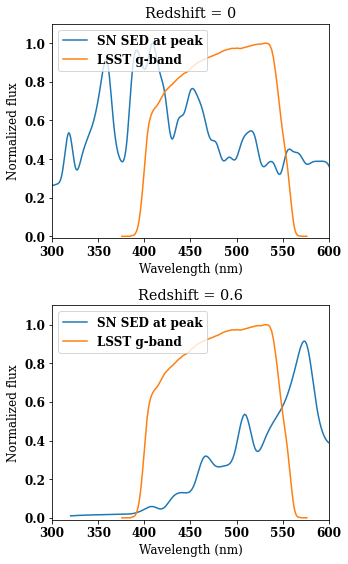

In [18]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

plt.subplots(2, 1, figsize = [5, 8])
plt.subplot(2, 1, 1)
plt.title('Redshift = 0')
plt.plot(SALT3_s0_epoch0[0]/10, SALT3_s0_epoch0[1]/np.max(SALT3_s0_epoch0[1]), label = 'SN SED at peak')
plt.plot(lsst_g_band[0]/10, lsst_g_band[1]/np.max(lsst_g_band[1]), label = 'LSST g-band')
plt.xlim(300, 600)
plt.ylim(-0.01, 1.1)
plt.legend(loc = 'upper left')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized flux')

plt.subplot(2, 1, 2)
plt.title('Redshift = 0.6')
plt.plot(SALT3_s0_epoch0[0]/10 * (1+0.6), SALT3_s0_epoch0[1]/np.max(SALT3_s0_epoch0[1]), label = 'SN SED at peak')
plt.plot(lsst_g_band[0]/10, lsst_g_band[1]/np.max(lsst_g_band[1]),  label = 'LSST g-band')
plt.xlim(300, 600)
plt.legend(loc = 'upper left')
plt.ylim(-0.01, 1.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized flux')

plt.tight_layout()

plt.savefig('DCR_AstroZ/results/Plots_for_Paper/SN_SED_and_LSST_g_band.png', dpi = 150)

In [19]:
no_lambda = sn_SEDs0['SALT3_SED_epoch0_no_treatment'].shape[0]

In [20]:
z_range = np.arange(0.00, 1.00, 0.01)

SALT3_epoch0_by_z = np.zeros([len(z_range), no_lambda, 2])

for z in range(len(z_range)):
    SALT3_epoch0_by_z[z] = np.array([SALT3_s0_epoch0[0] * (1+z_range[z]), SALT3_s0_epoch0[1]]).transpose()

AM_range = np.arange(1.00, 2.30, 0.01)
z_angles = np.arccos(1/AM_range)

ref_star_shift_by_band = np.zeros([len(z_angles), len(SNANA_lsst_bands)])
for a in range(len(z_angles)):
    for b in range(len(SNANA_lsst_bands)):
        ref_star_shift_by_band[a][b] = DCR_shift(z_angles[a], SNANA_lsst_bands[b], ref_star_SED) * 206264.806
    
SN_shift_by_z_band = np.zeros([len(z_range), len(z_angles), len(SNANA_lsst_bands)])


for z in range(len(z_range)):
    for a in range(len(z_angles)):
        for b in range(len(SNANA_lsst_bands)):
            SN_shift_by_z_band[z][a][b] = DCR_shift(z_angles[a], SNANA_lsst_bands[b], SALT3_epoch0_by_z[z]) * 206264.806

In [21]:
ref_star_SED_new_transp = ref_star_SED.transpose()[1]*5

In [22]:
ref_star_SED_new = np.array([ref_star_SED.transpose()[0], ref_star_SED.transpose()[1]*5]).transpose()
print(DCR_shift(z_angles[45], SNANA_lsst_bands[0], ref_star_SED) * 206264.806)
print(DCR_shift(z_angles[45], SNANA_lsst_bands[0], ref_star_SED_new) * 206264.806)

print(DCR_shift(z_angles[45], SNANA_lsst_bands[0], SALT3_epoch0_by_z[0]) * 206264.806)

48.50660647489561
48.50660647489561
48.50788396098575


In [23]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

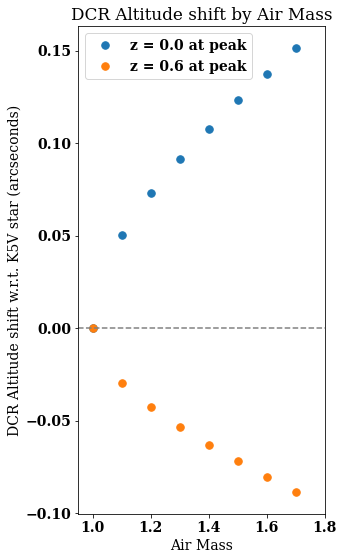

In [24]:
plt.figure(figsize = [5, 8])
plt.plot(AM_range[0:80:10], SN_shift_by_z_band[0].transpose()[1][0:80:10] - ref_star_shift_by_band.transpose()[1][0:80:10], '.', ms = 15, label = 'z = 0.0 at peak')
plt.plot(AM_range[0:80:10], SN_shift_by_z_band[60].transpose()[1][0:80:10] - ref_star_shift_by_band.transpose()[1][0:80:10], '.', ms = 15, label = 'z = 0.6 at peak')
plt.axhline(y = 0, ls = '--', color = 'gray')

plt.ylabel('DCR Altitude shift w.r.t. K5V star (arcseconds)')
plt.xlabel('Air Mass')
plt.title('DCR Altitude shift by Air Mass')
plt.legend()
plt.xlim(0.95, 1.8)
plt.tight_layout()
plt.savefig('DCR_AstroZ/results/Plots_for_Paper/DCR_shift_by_redshift_LSST.png', dpi = 150)

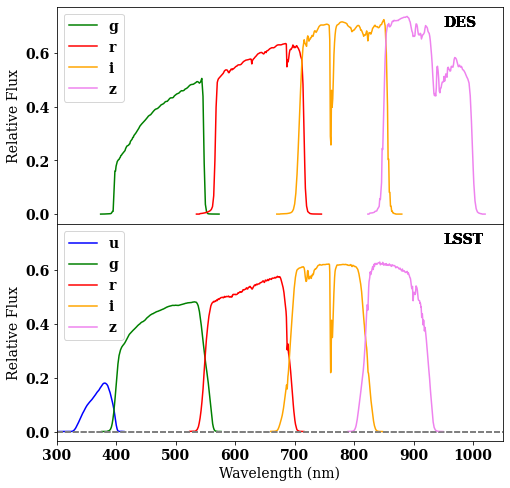

In [25]:
matplotlib.rc('font', **font)

plt.subplots(2, 1, sharey = True, figsize = [8, 8])

#plt.supylabel('Relative Frequency')


plt.subplot(2, 1, 1)

for b in range(len(SNANA_des_bands)):
    wave, flux = SNANA_des_bands[b].transpose()
    plt.plot(wave/10, flux, color = DES_band_colors[b], label = DES_bands[b])
    plt.text(950, 0.70, 'DES')
    plt.legend(loc = 'upper left')
    
plt.xlim(300, 1050)
plt.xticks([])
plt.ylabel('Relative Flux')
    
plt.subplot(2, 1, 2)

for b in range(len(SNANA_lsst_bands)):
    wave, flux = SNANA_lsst_bands[b].transpose()
    plt.plot(wave/10, flux, color = LSST_band_colors[b], label = LSST_bands[b])
    plt.text(950, 0.70, 'LSST')
    plt.axhline(y = 0.0, ls = '--', color = 'gray')
    plt.legend(loc = 'upper left')

plt.ylabel('Relative Flux')
plt.xlabel('Wavelength (nm)')
plt.xlim(300, 1050)


    
plt.subplots_adjust(hspace = 0.0) 
plt.savefig('DCR_AstroZ/results/Plots_for_Paper/filters_by_survey.png', dpi = 100)


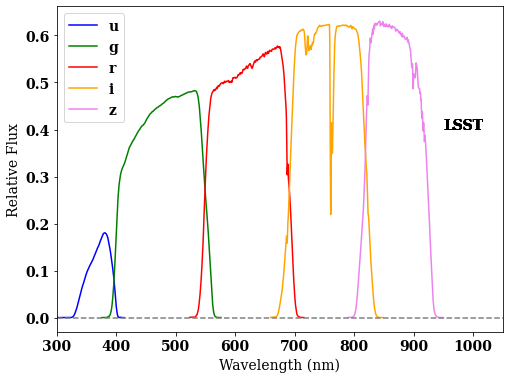

In [26]:
matplotlib.rc('font', **font)

plt.subplots(1, 1, sharey = True, figsize = [8, 6])

#plt.supylabel('Relative Frequency')


plt.subplot(1, 1, 1)

for b in range(len(SNANA_lsst_bands)):
    wave, flux = SNANA_lsst_bands[b].transpose()
    plt.plot(wave/10, flux, color = LSST_band_colors[b], label = LSST_bands[b])
    plt.text(950, 0.40, 'LSST')
    plt.legend(loc = 'upper left')
    
plt.axhline(y = 0.0, ls = '--', color = 'gray')
plt.xlim(300, 1050)
plt.ylabel('Relative Flux')
plt.xlabel('Wavelength (nm)')

plt.savefig('DCR_AstroZ/results/Plots_for_Paper/LSST_filters.png', dpi = 100)


In [27]:
dir_strs = ['JASON_DCR_ASTROZ_COADD_REALISTIC_v1113/', 'JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/', 'JASON_DCR_ASTROZ_COADD_PERFECT_v1113/']


In [28]:
z_bin_range = np.linspace(0, 1.20, num = 13)[:-1] + 0.1/2

In [36]:
type_strs_selection = ['no_cut', 'default', 'default+AM']#, 'Peaks == CDF50']

type_strs_stat = ['CDF50', 'Peaks']
#where_type = [np.arange(len(t_head)), where_SNR_stringent_cut_array, where_SNR_and_AM]#, where_both_match]

no_sel, no_stat = len(type_strs_selection), len(type_strs_stat)

SN_only, SN_only_ideal_tobs,  = np.zeros([no_sel, no_stat, len(z_bin_range), 4]), np.zeros([no_sel, no_stat, len(z_bin_range), 4])
gal_only, combined = np.zeros([no_sel, no_stat, len(z_bin_range), 4]), np.zeros([no_sel, no_stat, len(z_bin_range), 4])
combined_ideal_tobs = np.zeros([no_sel, no_stat, len(z_bin_range), 4])

In [37]:
for t in range(len(type_strs_selection)):
    for i in range(len(type_strs_stat)):
        SN_only[t][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_SN_only_binned_eta0.10.txt' %(type_strs_selection[t], type_strs_stat[i]))

In [38]:
for i in range(len(type_strs_stat)):
    gal_only[1][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_gal_only_binned_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]))
    combined[1][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_SN+gal_binned_eta_cut_3sqrt2sigma_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]))


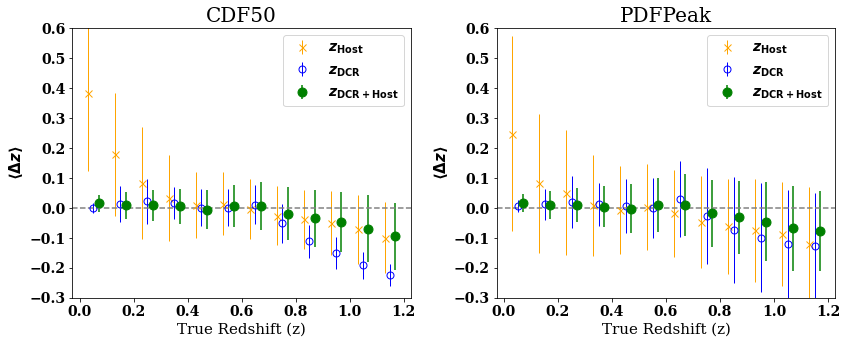

In [59]:
#SN only (no cut, default, default+AM); SN + gal (SN only, gal only, SN + gal); SN ideal tobs (SN vs. SN ideal tobs, maybe also combined)

type_strs_selection = ['No selection cut', 'Default S/N cut', r'S/N + AM cut']#, 'Peaks == CDF50']
type_strs_selection_sn_gal = [r'$z_{\rm{DCR}}$', r'$z_{\rm{Host}}$', r'$z_{\rm{DCR+Host}}$']
type_strs_selection_ideal = [r'Astro-z $t_{\mathrm{obs, real}}$', r'Astro-z $t_{\mathrm{obs, ideal}}$', r'Astro-z + Photo-z $t_{\mathrm{obs, real}}$', r'Astro-z + Photo-z $t_{\mathrm{obs, ideal}}$']

colors = ['orange', 'blue', 'green']

plt.subplots(1, 2, figsize = [12, 5])

title_strs = [r'CDF50', r'PDFPeak']

for i in range(len(type_strs_stat)):

    plt.subplot(1, 2, 1+i)
    plt.errorbar(z_bin_range - 0.02, gal_only[1][i].transpose()[0], yerr = gal_only[1][i].transpose()[1], fmt = 'x', color = colors[0], ms = 7, elinewidth = 1, label = type_strs_selection_sn_gal[1])
    plt.errorbar(z_bin_range, SN_only[1][i].transpose()[0], yerr = SN_only[1][i].transpose()[1], fmt = 'o', fillstyle='none', color = colors[1], ms = 7, elinewidth = 1,label = type_strs_selection_sn_gal[0])
    plt.errorbar(z_bin_range + 0.02, combined[1][i].transpose()[0], yerr = combined[1][i].transpose()[1], fmt = 'o', color = colors[2], ms = 9, elinewidth = 1.5, label = type_strs_selection_sn_gal[2])

    #plt.errorbar(zcut_range[:-1] + 0.05, residuals_all_perfect[0][0].transpose()[0], fmt = '.', label = 'Ideal SIMs') #, yerr = residuals_all[0][t].transpose()[1]
    plt.axhline(y = 0, ls = '--', color = 'gray')
    plt.legend(loc = 'upper right')
    plt.title(title_strs[i], fontsize = 20)
    plt.ylim(-0.3, 0.6)
    plt.ylabel(r'$\langle \Delta z \rangle$', fontsize = 15)
    plt.xlabel('True Redshift (z)', fontsize = 15)
    
plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/updated_240116/mean_residuals_realistic_1x2_v240117_eta_cut_3sqrt2sigma.png', dpi = 100)


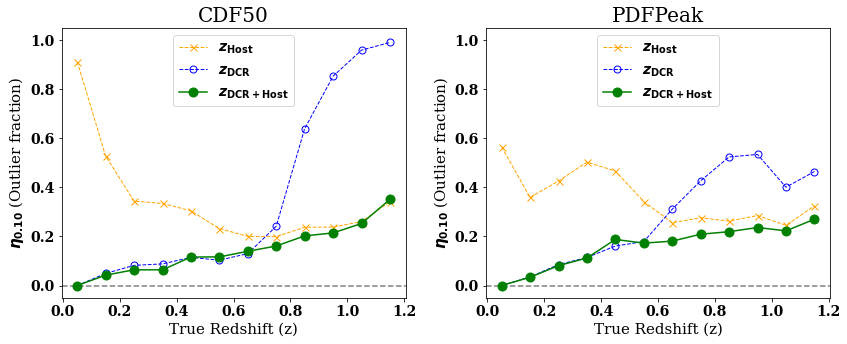

In [48]:
#SN only (no cut, default, default+AM); SN + gal (SN only, gal only, SN + gal); SN ideal tobs (SN vs. SN ideal tobs, maybe also combined)

type_strs_selection = ['No selection cut', 'Default S/N cut', r'S/N + AM cut']#, 'Peaks == CDF50']
type_strs_selection_sn_gal = [r'$z_{\rm{DCR}}$', r'$z_{\rm{Host}}$', r'$z_{\rm{DCR+Host}}$']
type_strs_selection_ideal = [r'Astro-z $t_{\mathrm{obs, real}}$', r'Astro-z $t_{\mathrm{obs, ideal}}$', r'Astro-z + Photo-z $t_{\mathrm{obs, real}}$', r'Astro-z + Photo-z $t_{\mathrm{obs, ideal}}$']

colors = ['orange', 'blue', 'green']

plt.subplots(1, 2, figsize = [12, 5])

title_strs = [r'CDF50', r'PDFPeak']

for i in range(len(type_strs_stat)):
    plt.subplot(1, 2, 1 + i)
    plt.errorbar(z_bin_range, gal_only[1][i].transpose()[2], fmt = '--x', color = colors[0], ms = 7, lw = 1, label = type_strs_selection_sn_gal[1])
    plt.errorbar(z_bin_range, SN_only[1][i].transpose()[2], fmt = '--o', fillstyle='none', color = colors[1], ms = 7, lw = 1, label = type_strs_selection_sn_gal[0])
    plt.errorbar(z_bin_range, combined[1][i].transpose()[2], fmt = '-o', color = colors[2], ms = 9, lw = 1.5, label = type_strs_selection_sn_gal[2])

    #plt.errorbar(zcut_range[:-1] + 0.05, residuals_all_perfect[0][0].transpose()[0], fmt = '.', label = 'Ideal SIMs') #, yerr = residuals_all[0][t].transpose()[1]
    plt.axhline(y = 0, ls = '--', color = 'gray')
    plt.legend(loc = 'upper center')
    plt.title(title_strs[i], fontsize = 20)
    plt.ylim(-0.05, 1.05)
    plt.ylabel(r'$\eta_{0.10}$ (Outlier fraction)', fontsize = 15)
    plt.xlabel('True Redshift (z)', fontsize = 15)
    
plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/eta0.10/outlier_rate_realistic_1x2_v240127_eta_cut_3sqrt2sigma.png', dpi = 100)


In [45]:
type_strs_with_lcfit = ['no_prior', 'host_prior', 'astro-z_prior', 'host_astro-z_prior']
type_strs_with_lcfit_compatible = 'host_astro-z_prior_compatible'
metrics_with_lcfit = np.zeros([len(type_strs_with_lcfit)+3, len(z_bin_range), 4])
for t in range(len(type_strs_with_lcfit)):
    metrics_with_lcfit[t] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_LCFIT+z_binned_FITPROB_eta0.10.txt' %type_strs_with_lcfit[t])


In [47]:
metrics_with_lcfit[4] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_LCFIT+z_binned_FITPROB_eta0.10.txt' %type_strs_with_lcfit_compatible)
#metrics_with_lcfit[5] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_LCFIT+z_binned_FITPROB_cosmology_prior_eta0.10.txt' %type_strs_with_lcfit_compatible)
metrics_with_lcfit[6] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_LCFIT+z_binned_FITPROB_cosmology_prior_eta0.10.txt' %type_strs_with_lcfit[0])

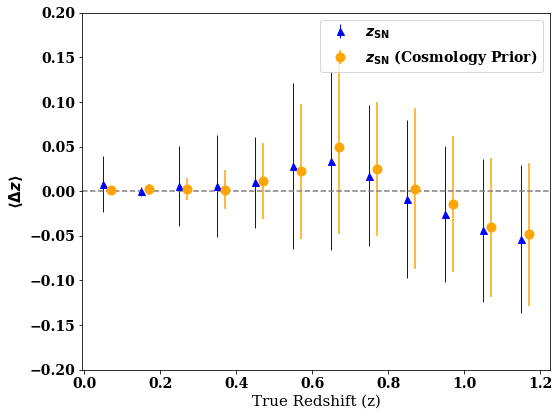

In [63]:
#SN only (no cut, default, default+AM); SN + gal (SN only, gal only, SN + gal); SN ideal tobs (SN vs. SN ideal tobs, maybe also combined)

type_strs_with_lcfit_label = [r'$z_{\rm{SN+Host}}$', r'$z_{\rm{SN}}$', r'$z_{\rm{SN+DCR}}$', r'$z_{\rm{SN+DCR+Host}}$']

colors = ['orange', 'blue', 'green', 'red']

plt.figure(figsize = [8, 6])

plt.errorbar(z_bin_range, metrics_with_lcfit[0].transpose()[0], yerr = metrics_with_lcfit[0].transpose()[1], fmt = '^', color = colors[1], ms = 7, elinewidth = 1,label = type_strs_with_lcfit_label[1])
plt.errorbar(z_bin_range + 0.02, metrics_with_lcfit[6].transpose()[0], yerr = metrics_with_lcfit[6].transpose()[1], fmt = 'o', color = colors[0], ms = 9, elinewidth = 1.5, label = type_strs_with_lcfit_label[1] + ' (Cosmology Prior)')

#plt.errorbar(zcut_range[:-1] + 0.05, residuals_all_perfect[0][0].transpose()[0], fmt = '.', label = 'Ideal SIMs') #, yerr = residuals_all[0][t].transpose()[1]
plt.axhline(y = 0, ls = '--', color = 'gray')
plt.legend(loc = 'best')
plt.ylim(-0.2, 0.2)
plt.ylabel(r'$\langle \Delta z \rangle$', fontsize = 15)
plt.xlabel('True Redshift (z)', fontsize = 15)
    
plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/eta0.10/mean_residuals_SN_only_realistic_with_lcfit_v240127_cosmology_prior_comparison.png', dpi = 100, facecolor = 'white')


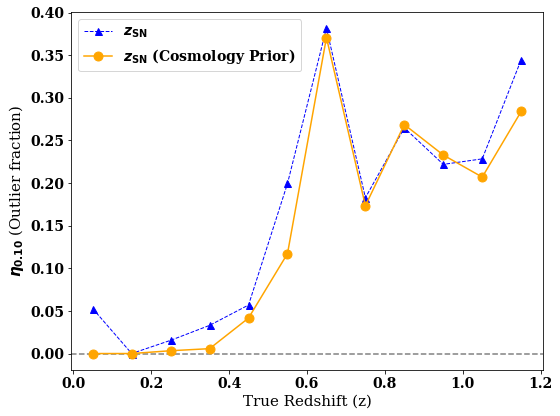

In [56]:
#SN only (no cut, default, default+AM); SN + gal (SN only, gal only, SN + gal); SN ideal tobs (SN vs. SN ideal tobs, maybe also combined)

type_strs_with_lcfit_label = [r'$z_{\rm{SN+Host}}$', r'$z_{\rm{SN}}$', r'$z_{\rm{SN+DCR}}$', r'$z_{\rm{SN+DCR+Host}}$']

colors = ['orange', 'blue', 'green', 'red']

plt.figure(figsize = [8, 6])

plt.errorbar(z_bin_range, metrics_with_lcfit[0].transpose()[2], fmt = '--^', color = colors[1], ms = 7, lw = 1, label = type_strs_with_lcfit_label[1])
plt.errorbar(z_bin_range, metrics_with_lcfit[6].transpose()[2], fmt = '-o', color = colors[0], ms = 9, lw = 1.5, label = type_strs_with_lcfit_label[1] + ' (Cosmology Prior)')


#plt.errorbar(zcut_range[:-1] + 0.05, residuals_all_perfect[0][0].transpose()[0], fmt = '.', label = 'Ideal SIMs') #, yerr = residuals_all[0][t].transpose()[1]
plt.axhline(y = 0, ls = '--', color = 'gray')
plt.legend(loc = 'best')
#plt.ylim(-0.2, 0.2)
plt.ylabel(r'$\eta_{0.10}$ (Outlier fraction)', fontsize = 15)
plt.xlabel('True Redshift (z)', fontsize = 15)
    
plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/eta0.10/outlier_rates_SN_only_realistic_with_lcfit_v240127_cosmology_prior_comparison.png', dpi = 100, facecolor = 'white')


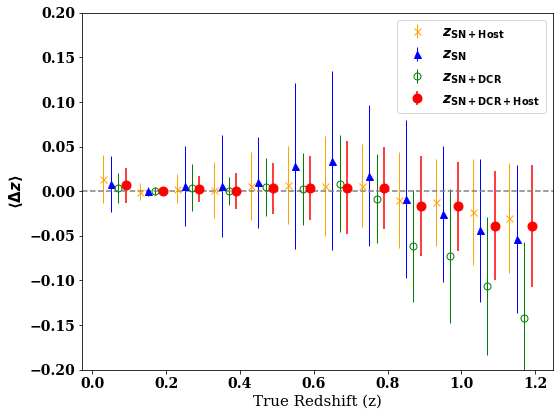

In [66]:
#SN only (no cut, default, default+AM); SN + gal (SN only, gal only, SN + gal); SN ideal tobs (SN vs. SN ideal tobs, maybe also combined)

type_strs_with_lcfit_label = [r'$z_{\rm{SN+Host}}$', r'$z_{\rm{SN}}$', r'$z_{\rm{SN+DCR}}$', r'$z_{\rm{SN+DCR+Host}}$']

colors = ['orange', 'blue', 'green', 'red']

plt.figure(figsize = [8, 6])

plt.errorbar(z_bin_range - 0.02, metrics_with_lcfit[1].transpose()[0], yerr = metrics_with_lcfit[1].transpose()[1], fmt = 'x', color = colors[0], ms = 7, elinewidth = 1, label = type_strs_with_lcfit_label[0])
plt.errorbar(z_bin_range, metrics_with_lcfit[0].transpose()[0], yerr = metrics_with_lcfit[0].transpose()[1], fmt = '^', color = colors[1], ms = 7, elinewidth = 1,label = type_strs_with_lcfit_label[1])
plt.errorbar(z_bin_range + 0.02, metrics_with_lcfit[2].transpose()[0], yerr = metrics_with_lcfit[2].transpose()[1], fmt = 'o', fillstyle='none', color = colors[2], ms = 7, elinewidth = 1, label = type_strs_with_lcfit_label[2])
plt.errorbar(z_bin_range + 0.04, metrics_with_lcfit[4].transpose()[0], yerr = metrics_with_lcfit[4].transpose()[1], fmt = 'o', color = colors[3], ms = 9, elinewidth = 1.5, label = type_strs_with_lcfit_label[3])

#plt.errorbar(zcut_range[:-1] + 0.05, residuals_all_perfect[0][0].transpose()[0], fmt = '.', label = 'Ideal SIMs') #, yerr = residuals_all[0][t].transpose()[1]
plt.axhline(y = 0, ls = '--', color = 'gray')
plt.legend(loc = 'best')
plt.ylim(-0.2, 0.2)
plt.ylabel(r'$\langle \Delta z \rangle$', fontsize = 15)
plt.xlabel('True Redshift (z)', fontsize = 15)
    
plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/updated_240116/mean_residuals_realistic_with_lcfit_v240117_incompatible_priors_considered_FITPROB.png', dpi = 100)


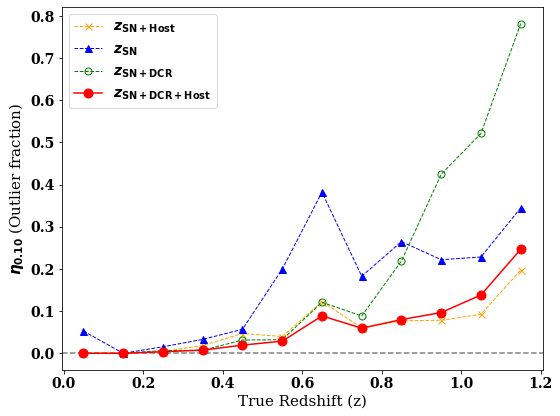

In [55]:
#SN only (no cut, default, default+AM); SN + gal (SN only, gal only, SN + gal); SN ideal tobs (SN vs. SN ideal tobs, maybe also combined)

type_strs_with_lcfit_label = [r'$z_{\rm{SN+Host}}$', r'$z_{\rm{SN}}$', r'$z_{\rm{SN+DCR}}$', r'$z_{\rm{SN+DCR+Host}}$']

colors = ['orange', 'blue', 'green', 'red']

plt.figure(figsize = [8, 6])

plt.errorbar(z_bin_range, metrics_with_lcfit[1].transpose()[2], fmt = '--x', color = colors[0], ms = 7, lw = 1, label = type_strs_with_lcfit_label[0])
plt.errorbar(z_bin_range, metrics_with_lcfit[0].transpose()[2], fmt = '--^', color = colors[1], ms = 7, lw = 1, label = type_strs_with_lcfit_label[1])
plt.errorbar(z_bin_range, metrics_with_lcfit[2].transpose()[2], fmt = '--o', fillstyle='none', color = colors[2], ms = 7, lw = 1, label = type_strs_with_lcfit_label[2])
plt.errorbar(z_bin_range, metrics_with_lcfit[4].transpose()[2], fmt = '-o', color = colors[3], ms = 9, lw = 1.5, label = type_strs_with_lcfit_label[3])

#plt.errorbar(zcut_range[:-1] + 0.05, residuals_all_perfect[0][0].transpose()[0], fmt = '.', label = 'Ideal SIMs') #, yerr = residuals_all[0][t].transpose()[1]
plt.axhline(y = 0, ls = '--', color = 'gray')
plt.legend(loc = 'best')
#plt.ylim(-0.2, 0.2)
plt.ylabel(r'$\eta_{0.10}$ (Outlier fraction)', fontsize = 15)
plt.xlabel('True Redshift (z)', fontsize = 15)
    
plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/eta0.10/outlier_rate_realistic_with_lcfit_v240127_incompatible_priors_considered.png', dpi = 100)


In [51]:
SN_perfect = np.zeros([no_stat, len(z_bin_range), 4])


In [52]:
for i in range(len(type_strs_stat)):
    SN_perfect[i] = np.loadtxt('DCR_AstroZ/' + dir_strs[2] + dir_strs[2][:-1] + '_z_metrics_type_%d_binned_no_marg_1_5mas_eta0.10.txt' %i)


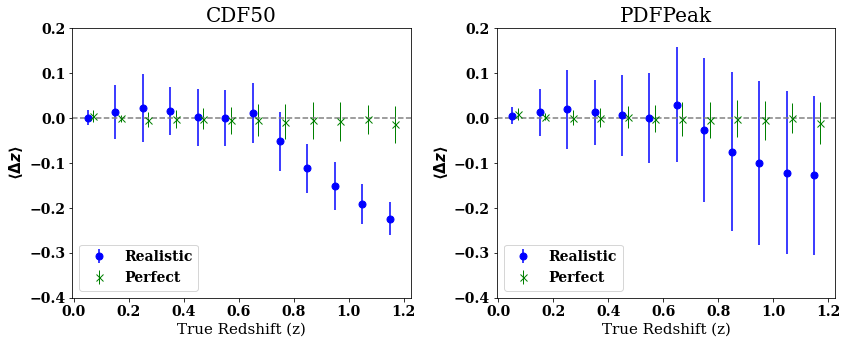

In [73]:
#SN only (no cut, default, default+AM); SN + gal (SN only, gal only, SN + gal); SN ideal tobs (SN vs. SN ideal tobs, maybe also combined)

type_strs_selection_sims = [r'$\sigma_{\mathrm{syst}}$ only', r'Realistic', r'Perfect']#, 'Peaks == CDF50']

colors = ['orange', 'blue', 'green']

plt.subplots(1, 2, figsize = [12, 5])

title_strs = [r'CDF50', r'PDFPeak']

for i in range(len(type_strs_stat)):
    plt.subplot(1, 2, i + 1)
    #plt.errorbar(z_bin_range - 0.02, SN_syst_only[i].transpose()[0], yerr = SN_syst_only[i].transpose()[1], fmt = '.', color = colors[0], ms = 9, elinewidth = 1, label = type_strs_selection_sims[0])
    plt.errorbar(z_bin_range, SN_only[1][i].transpose()[0], yerr = SN_only[1][i].transpose()[1], fmt = 'o', color = colors[1], ms = 7, elinewidth = 1.5, label = type_strs_selection_sims[1])
    plt.errorbar(z_bin_range + 0.02, SN_perfect[i].transpose()[0], yerr = SN_perfect[i].transpose()[1], fmt = 'x', color = colors[2], ms = 7, elinewidth = 1, label = type_strs_selection_sims[2])
#plt.errorbar(zcut_range[:-1] + 0.05, residuals_all_perfect[0][0].transpose()[0], fmt = '.', label = 'Ideal SIMs') #, yerr = residuals_all[0][t].transpose()[1]
    plt.axhline(y = 0, ls = '--', color = 'gray')
    plt.legend(loc = 'lower left')
    plt.title(title_strs[i], fontsize = 20)
    plt.ylim(-0.4, 0.2)
    plt.ylabel(r'$\langle \Delta z \rangle$', fontsize = 15)
    plt.xlabel('True Redshift (z)', fontsize = 15)

    
plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/updated_240116/mean_residuals_different_sims_v240117_1_5mas.png', dpi = 100)


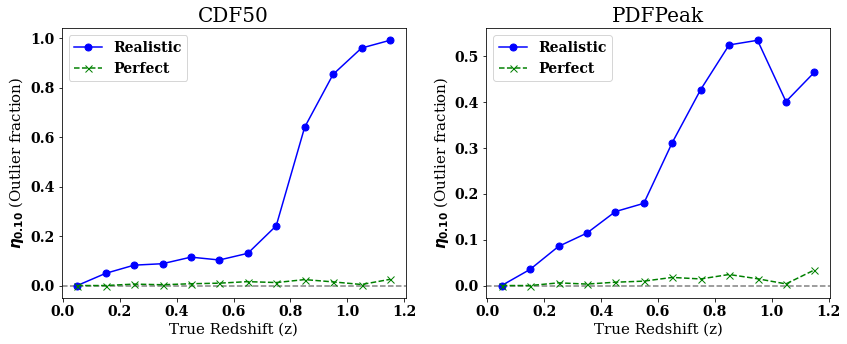

In [54]:
#SN only (no cut, default, default+AM); SN + gal (SN only, gal only, SN + gal); SN ideal tobs (SN vs. SN ideal tobs, maybe also combined)

type_strs_selection_sims = [r'$\sigma_{\mathrm{syst}}$ only', r'Realistic', r'Perfect']#, 'Peaks == CDF50']

colors = ['orange', 'blue', 'green']

plt.subplots(1, 2, figsize = [12, 5])

title_strs = [r'CDF50', r'PDFPeak']

for i in range(len(type_strs_stat)):
    plt.subplot(1, 2, i + 1)
    #plt.errorbar(z_bin_range - 0.02, SN_syst_only[i].transpose()[0], yerr = SN_syst_only[i].transpose()[1], fmt = '.', color = colors[0], ms = 9, elinewidth = 1, label = type_strs_selection_sims[0])
    plt.errorbar(z_bin_range, SN_only[1][i].transpose()[2], fmt = '-o', color = colors[1], ms = 7, elinewidth = 1.5, label = type_strs_selection_sims[1])
    plt.errorbar(z_bin_range, SN_perfect[i].transpose()[2], fmt = '--x', color = colors[2], ms = 7, elinewidth = 1, label = type_strs_selection_sims[2])
#plt.errorbar(zcut_range[:-1] + 0.05, residuals_all_perfect[0][0].transpose()[0], fmt = '.', label = 'Ideal SIMs') #, yerr = residuals_all[0][t].transpose()[1]
    plt.axhline(y = 0, ls = '--', color = 'gray')
    plt.legend(loc = 'upper left')
    plt.title(title_strs[i], fontsize = 20)
    plt.ylabel(r'$\eta_{0.10}$ (Outlier fraction)', fontsize = 15)
    plt.xlabel('True Redshift (z)', fontsize = 15)

    
plt.tight_layout()

plt.savefig('/pscratch/sd/a/astjason/DCR_AstroZ/results/Plots_for_Paper/eta0.10/outlier_rate_different_sims_v240127_1_5mas.png', dpi = 100)


In [71]:
z_bin_range = [0.6]

In [74]:
np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_SN_only_all_z_eta0.10.txt' %(type_strs_selection[t], type_strs_stat[i]))

array([-0.06307108,  0.19573876,  0.00138408,  0.4413    ,  0.12155982])

In [76]:
SN_only = np.zeros([no_sel, no_stat, len(z_bin_range), 5])
gal_only, combined = np.zeros([no_sel, no_stat, len(z_bin_range), 5]), np.zeros([no_sel, no_stat, len(z_bin_range), 5])
SN_only_fmax_clump, SN_only_ideal_tobs = np.zeros([no_stat, len(z_bin_range), 5]), np.zeros([no_stat, len(z_bin_range), 5])

type_strs_selection = ['no_cut', 'default', 'default+AM', 'fmax_clump', 'ideal_tobs']

for t in range(len(type_strs_selection[:3])):
    for i in range(len(type_strs_stat)):
        SN_only[t][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_SN_only_all_z_eta0.10.txt' %(type_strs_selection[t], type_strs_stat[i]))

for i in range(len(type_strs_stat)):
    SN_only_fmax_clump[i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_SN_only_all_z_eta0.10.txt' %(type_strs_selection[3], type_strs_stat[i]))
    SN_only_ideal_tobs[i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_SN_only_all_z_eta0.10.txt' %(type_strs_selection[4], type_strs_stat[i]))
    gal_only[1][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_gal_only_all_z_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]))
    combined[1][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_SN+gal_all_z_eta_cut_3sqrt2sigma_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]))

type_strs_with_lcfit = ['no_prior', 'host_prior', 'astro-z_prior', 'host_astro-z_prior']
metrics_with_lcfit = np.zeros([len(type_strs_with_lcfit)+1, len(z_bin_range), 5])
for t in range(len(type_strs_with_lcfit)):
    metrics_with_lcfit[t] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_LCFIT+z_all_z_FITPROB_eta0.10.txt' %type_strs_with_lcfit[t])
metrics_with_lcfit[4] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_LCFIT+z_all_z_FITPROB_eta0.10.txt' %type_strs_with_lcfit_compatible)


In [77]:
SN_syst_only, SN_perfect  = np.zeros([no_stat, len(z_bin_range), 5]), np.zeros([no_stat, len(z_bin_range), 5])


In [78]:
for i in range(len(type_strs_stat)):
    #SN_syst_only[i] = np.loadtxt('DCR_AstroZ/' + dir_strs[1] + dir_strs[1][:-1] + '_z_metrics_type_%d_all_z.txt' %i)
    SN_perfect[i] = np.loadtxt('DCR_AstroZ/' + dir_strs[2] + dir_strs[2][:-1] + '_z_metrics_type_%d_all_z_no_marg_1_5mas_eta0.10.txt' %i)


In [79]:
df = pd.DataFrame(dict(Type=['No selection cut', 'Epoch cut', 'Epoch + S/N cut'],
                       Number =[20000, 13821, 8622]))

In [80]:
print(df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format))

\begin{tabular}{lr}
\toprule
            Type &  Number \\
\midrule
No selection cut &   20000 \\
       Epoch cut &   13821 \\
 Epoch + S/N cut &    8622 \\
\bottomrule
\end{tabular}



In [82]:
#+SN-Photo-z

#12682 7310
#12374 7194
#12223 7654
#12843 7587


In [83]:
import pandas as pd

#from uutils import put_pm_to_pandas_data

def put_pm_to_pandas_data(data: dict) -> dict:
    """
    Change the +- to \pm for latex display.

    ref:
        - https://stackoverflow.com/questions/70008992/how-to-print-a-literal-backslash-to-get-pm-in-a-pandas-data-frame-to-generate-a
    """
    for column_name, data_values in data.items():
        # data[column_name] = [data_value.replace('+-', r'\pm') for data_value in data_values]
        data[column_name] = [data_value.replace('+-', r'$\pm$') for data_value in data_values]
        # data[column_name] = [data_value.replace('+-', '\pm') for data_value in data_values]
    return data

In [84]:
#data = {'Type': ['Perfect', r'$\sigma_{\mathrm{syst}}$ only', 'Realistic'],
#       'Bias (CDF50)': ['%.3f+-%.3f' %(SN_perfect[0][0][0], SN_perfect[0][0][1]), '%.3f+-%.3f' %(SN_syst_only[0][0][0], SN_syst_only[0][0][1]), '%.3f+-%.3f' %(SN_only[1][0][0][0], SN_only[1][0][0][1])], 
#       'Bias (Peaks)': ['%.3f+-%.3f' %(SN_perfect[1][0][0], SN_perfect[1][0][1]), '%.3f+-%.3f' %(SN_syst_only[1][0][0], SN_syst_only[1][0][1]), '%.3f+-%.3f' %(SN_only[1][1][0][0], SN_only[1][1][0][1])], 
#       'Outlier Rate (CDF50)': ['%.3f' %SN_perfect[0][0][2], '%.3f' %SN_syst_only[0][0][2], '%.3f' %SN_only[1][0][0][2]], 
#       'Outlier Rate (Peaks)': ['%.3f' %SN_perfect[1][0][2], '%.3f' %SN_syst_only[1][0][2], '%.3f' %SN_only[1][1][0][2]]}

In [85]:
#Place Holder 240119 10PM KST

In [97]:
data = {'Type': ['Perfect', 'Realistic'],
       'Bias (CDF50)': ['%.3f+-%.3f(%.3f)' %(SN_perfect[0][0][0], SN_perfect[0][0][2], SN_perfect[0][0][1]), '%.3f+-%.3f(%.3f)' %(SN_only[1][0][0][0], SN_only[1][0][0][2], SN_only[1][0][0][1])], 
       'Bias (PDFPeak)': ['%.3f+-%.3f(%.3f)' %(SN_perfect[1][0][0], SN_perfect[1][0][2], SN_perfect[1][0][1]), '%.3f+-%.3f(%.3f)' %(SN_only[1][1][0][0], SN_only[1][1][0][2], SN_only[1][1][0][1])], 
       '$\eta_{0.10}$ (C50)': ['%.3f' %SN_perfect[0][0][3], '%.3f' %SN_only[1][0][0][3]], 
       '$\eta_{0.10}$ (PPeak)': ['%.3f' %SN_perfect[1][0][3], '%.3f' %SN_only[1][1][0][3]], 
        '$\sigma_{\rm{MAD}}$ (C50)': ['%.3f' %SN_perfect[0][0][4], '%.3f' %SN_only[1][0][0][4]], 
       '$\sigma_{\rm{MAD}}$ (PPeak)': ['%.3f' %SN_perfect[1][0][4], '%.3f' %SN_only[1][1][0][4]]}

In [98]:
df = pd.DataFrame(data)
print(df)
data = put_pm_to_pandas_data(data)
df = pd.DataFrame(data)

print(df.to_latex(index=False, escape = False))

        Type          Bias (CDF50)        Bias (PDFPeak) $\eta_{0.10}$ (C50)  \
0    Perfect  -0.006+-0.000(0.036)  -0.003+-0.000(0.038)               0.014   
1  Realistic  -0.049+-0.001(0.092)  -0.026+-0.002(0.149)               0.342   

  $\eta_{0.10}$ (PPeak) $\sigma_{\rm{MAD}}$ (C50) $\sigma_{\rm{MAD}}$ (PPeak)  
0                 0.015                     0.008                       0.008  
1                 0.330                     0.088                       0.077  
\begin{tabular}{lllllll}
\toprule
     Type &            Bias (CDF50) &          Bias (PDFPeak) & $\eta_{0.10}$ (C50) & $\eta_{0.10}$ (PPeak) & $\sigma_{\rm{MAD}}$ (C50) & $\sigma_{\rm{MAD}}$ (PPeak) \\
\midrule
  Perfect & -0.006$\pm$0.000(0.036) & -0.003$\pm$0.000(0.038) &               0.014 &                 0.015 &                     0.008 &                       0.008 \\
Realistic & -0.049$\pm$0.001(0.092) & -0.026$\pm$0.002(0.149) &               0.342 &                 0.330 &                     0.088 & 

In [101]:
data_SN_only = {'Type': ['No selection cut', 'Default', 'Default + AM cut', 'Fmax-clump', 'Ideal $t_{\mathrm{obs}}$'],
       'Bias (CDF50)': ['%.3f+-%.3f(%.3f)' %(SN_only[0][0][0][0], SN_only[0][0][0][2], SN_only[0][0][0][1]), '%.3f+-%.3f(%.3f)' %(SN_only[1][0][0][0], SN_only[1][0][0][2], SN_only[1][0][0][1]), '%.3f+-%.3f(%.3f)' %(SN_only[2][0][0][0], SN_only[2][0][0][2], SN_only[2][0][0][1]), '%.3f+-%.3f(%.3f)' %(SN_only_fmax_clump[0][0][0], SN_only_fmax_clump[0][0][2], SN_only_fmax_clump[0][0][1]), '%.3f+-%.3f(%.3f)' %(SN_only_ideal_tobs[0][0][0], SN_only_ideal_tobs[0][0][2], SN_only_ideal_tobs[0][0][1])], 
       'Bias (PDFPeak)': ['%.3f+-%.3f(%.3f)' %(SN_only[0][1][0][0], SN_only[0][1][0][2], SN_only[0][1][0][1]), '%.3f+-%.3f(%.3f)' %(SN_only[1][1][0][0], SN_only[1][1][0][2], SN_only[1][1][0][1]), '%.3f+-%.3f(%.3f)' %(SN_only[2][1][0][0], SN_only[2][1][0][2], SN_only[2][1][0][1]), '%.3f+-%.3f(%.3f)' %(SN_only_fmax_clump[1][0][0], SN_only_fmax_clump[1][0][2], SN_only_fmax_clump[1][0][1]), '%.3f+-%.3f(%.3f)' %(SN_only_ideal_tobs[1][0][0], SN_only_ideal_tobs[1][0][2], SN_only_ideal_tobs[1][0][1])], 
       '$\eta_{0.10}$ (C50)': ['%.3f' %SN_only[0][0][0][3], '%.3f' %SN_only[1][0][0][3], '%.3f' %SN_only[2][0][0][3], '%.3f' %SN_only_fmax_clump[0][0][3], '%.3f' %SN_only_ideal_tobs[0][0][3]],
       '$\eta_{0.10}$ (PPeak)': ['%.3f' %SN_only[0][1][0][3], '%.3f' %SN_only[1][1][0][3], '%.3f' %SN_only[2][1][0][3], '%.3f' %SN_only_fmax_clump[1][0][3], '%.3f' %SN_only_ideal_tobs[1][0][3]], 
       '$\sigma_{\rm{MAD}}$ (C50)': ['%.3f' %SN_only[0][0][0][4], '%.3f' %SN_only[1][0][0][4], '%.3f' %SN_only[2][0][0][4], '%.3f' %SN_only_fmax_clump[0][0][4], '%.3f' %SN_only_ideal_tobs[0][0][4]],
       '$\sigma_{\rm{MAD}}$ (PPeak)': ['%.3f' %SN_only[0][1][0][4], '%.3f' %SN_only[1][1][0][4], '%.3f' %SN_only[2][1][0][4], '%.3f' %SN_only_fmax_clump[1][0][4], '%.3f' %SN_only_ideal_tobs[1][0][4]], }

In [102]:
df = pd.DataFrame(data_SN_only)
print(df)
data = put_pm_to_pandas_data(data_SN_only)
df = pd.DataFrame(data_SN_only)

print(df.to_latex(index=False, escape = False))

                       Type         Bias (CDF 50)        Bias (PDFPeak)  \
0          No selection cut  -0.103+-0.001(0.114)  -0.063+-0.001(0.196)   
1                   Default  -0.049+-0.001(0.092)  -0.026+-0.002(0.149)   
2          Default + AM cut  -0.043+-0.001(0.090)  -0.022+-0.002(0.142)   
3                Fmax-clump  -0.050+-0.001(0.094)  -0.028+-0.002(0.152)   
4  Ideal $t_{\mathrm{obs}}$  -0.050+-0.001(0.089)  -0.028+-0.002(0.147)   

  $\eta_{0.10}$ (C50) $\eta_{0.10}$ (PPeak) $\sigma_{\rm{MAD}}$ (C50)  \
0               0.579                 0.441                     0.138   
1               0.342                 0.330                     0.088   
2               0.315                 0.311                     0.081   
3               0.353                 0.346                     0.090   
4               0.333                 0.321                     0.085   

  $\sigma_{\rm{MAD}}$ (PPeak)  
0                       0.122  
1                       0.077  
2             

In [91]:
gal_only.shape

(3, 2, 1, 4)

In [106]:
data_SN_host= {'Type': ['$z_{\rm{DCR}}$', '$z_{\rm{Host}}$', '$z_{\rm{DCR+Host}}$'],
       'Bias (CDF50)': ['%.3f+-%.3f(%.3f)' %(SN_only[1][0][0][0], SN_only[1][0][0][2], SN_only[1][0][0][1]), '%.3f+-%.3f(%.3f)' %(gal_only[1][0][0][0], gal_only[1][0][0][2], gal_only[1][0][0][1]), '%.3f+-%.3f(%.3f)' %(combined[1][0][0][0], combined[1][0][0][2], combined[1][0][0][1])], 
       'Bias (PDFPeak)': ['%.3f+-%.3f(%.3f)' %(SN_only[1][1][0][0], SN_only[1][1][0][2], SN_only[1][1][0][1]), '%.3f+-%.3f(%.3f)' %(gal_only[1][1][0][0], gal_only[1][1][0][2], gal_only[1][1][0][1]), '%.3f+-%.3f(%.3f)' %(combined[1][1][0][0], combined[1][1][0][2], combined[1][1][0][1])], 
       '$\eta_{0.10}$ (C50)': ['%.3f' %SN_only[1][0][0][3], '%.3f' %gal_only[1][0][0][3], '%.3f' %combined[1][0][0][3]],
       '$\eta_{0.10}$ (PPeak)': ['%.3f' %SN_only[1][1][0][3], '%.3f' %gal_only[1][1][0][3], '%.3f' %combined[1][1][0][3]],
       '$\sigma_{\rm{MAD}}$ (C50)': ['%.3f' %SN_only[1][0][0][4], '%.3f' %gal_only[1][0][0][4], '%.3f' %combined[1][0][0][4]],
       '$\sigma_{\rm{MAD}}$ (PPeak)': ['%.3f' %SN_only[1][1][0][4], '%.3f' %gal_only[1][1][0][4], '%.3f' %combined[1][1][0][4]]}

In [107]:
df = pd.DataFrame(data_SN_host)
print(df)
data = put_pm_to_pandas_data(data_SN_host)
df = pd.DataFrame(data_SN_host)

print(df.to_latex(index=False, escape = False))

                  Type          Bias (CDF50)        Bias (PDFPeak)  \
0       $z_{\rm{DCR}}$  -0.049+-0.001(0.092)  -0.026+-0.002(0.149)   
1      $z_{\rm{Host}}$  -0.008+-0.001(0.124)  -0.029+-0.002(0.166)   
2  $z_{\rm{DCR+Host}}$  -0.016+-0.001(0.087)  -0.014+-0.001(0.109)   

  $\eta_{0.10}$ (C50) $\eta_{0.10}$ (PPeak) $\sigma_{\rm{MAD}}$ (C50)  \
0               0.342                 0.330                     0.088   
1               0.252                 0.324                     0.067   
2               0.154                 0.190                     0.047   

  $\sigma_{\rm{MAD}}$ (PPeak)  
0                       0.077  
1                       0.083  
2                       0.051  
\begin{tabular}{lllllll}
\toprule
               Type &            Bias (CDF50) &          Bias (PDFPeak) & $\eta_{0.10}$ (C50) & $\eta_{0.10}$ (PPeak) & $\sigma_{\rm{MAD}}$ (C50) & $\sigma_{\rm{MAD}}$ (PPeak) \\
\midrule
     $z_{\rm{DCR}}$ & -0.049$\pm$0.001(0.092) & -0.026$\pm$0.002(0.149) &   

In [110]:
data_SN_photo_z= {'Type': ['$z_{\rm{SN}}$', '$z_{\rm{SN+Host}}$', '$z_{\rm{SN+DCR}}$', '$z_{\rm{SN+DCR+Host}}$'],
       'Bias': ['%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[0][0][0], metrics_with_lcfit[0][0][2], metrics_with_lcfit[0][0][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[1][0][0], metrics_with_lcfit[1][0][2], metrics_with_lcfit[1][0][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[2][0][0], metrics_with_lcfit[2][0][2], metrics_with_lcfit[2][0][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[3][0][0], metrics_with_lcfit[3][0][2], metrics_with_lcfit[3][0][1])], 
       '$\eta_{0.10}$': ['%.3f' %metrics_with_lcfit[0][0][3], '%.3f' %metrics_with_lcfit[1][0][3], '%.3f' %metrics_with_lcfit[2][0][3], '%.3f' %metrics_with_lcfit[3][0][3]], 
       '$\sigma_{\rm{MAD}}$': ['%.3f' %metrics_with_lcfit[0][0][4], '%.3f' %metrics_with_lcfit[1][0][4], '%.3f' %metrics_with_lcfit[2][0][4], '%.3f' %metrics_with_lcfit[3][0][4]]}

In [111]:
df = pd.DataFrame(data_SN_photo_z)
print(df)
data = put_pm_to_pandas_data(data_SN_photo_z)
df = pd.DataFrame(data_SN_photo_z)

print(df.to_latex(index=False, escape = False))

                     Type                  Bias $\eta_{0.10}$  \
0           $z_{\rm{SN}}$   0.006+-0.001(0.084)         0.205   
1      $z_{\rm{SN+Host}}$  -0.001+-0.001(0.048)         0.068   
2       $z_{\rm{SN+DCR}}$  -0.021+-0.001(0.063)         0.146   
3  $z_{\rm{SN+DCR+Host}}$  -0.004+-0.001(0.047)         0.062   

  $\sigma_{\rm{MAD}}$  
0               0.025  
1               0.016  
2               0.017  
3               0.014  
\begin{tabular}{llll}
\toprule
                  Type &                    Bias & $\eta_{0.10}$ & $\sigma_{\rm{MAD}}$ \\
\midrule
         $z_{\rm{SN}}$ &  0.006$\pm$0.001(0.084) &         0.205 &               0.025 \\
    $z_{\rm{SN+Host}}$ & -0.001$\pm$0.001(0.048) &         0.068 &               0.016 \\
     $z_{\rm{SN+DCR}}$ & -0.021$\pm$0.001(0.063) &         0.146 &               0.017 \\
$z_{\rm{SN+DCR+Host}}$ & -0.004$\pm$0.001(0.047) &         0.062 &               0.014 \\
\bottomrule
\end{tabular}



In [150]:
z_bin_range = [0.3, 0.9]

SN_only, SN_only_ideal_tobs  = np.zeros([no_sel, no_stat, len(z_bin_range), 5]), np.zeros([no_sel, no_stat, len(z_bin_range), 5])
gal_only, combined = np.zeros([no_sel, no_stat, len(z_bin_range), 5]), np.zeros([no_sel, no_stat, len(z_bin_range), 5])
combined_ideal_tobs = np.zeros([no_sel, no_stat, len(z_bin_range), 5])

type_strs_selection = ['no_cut', 'default', 'default+AM']

for t in range(len(type_strs_selection)):
    for i in range(len(type_strs_stat)):
        SN_only[t][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_SN_only_high_low_z_eta0.10.txt' %(type_strs_selection[t], type_strs_stat[i]))
for i in range(len(type_strs_stat)):
    gal_only[1][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_gal_only_high_low_z_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]))
    combined[1][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_SN+gal_high_low_z_eta_cut_3sqrt2sigma_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]))

        
type_strs_with_lcfit = ['no_prior', 'host_prior', 'astro-z_prior', 'host_astro-z_prior']
metrics_with_lcfit = np.zeros([len(type_strs_with_lcfit), len(z_bin_range), 5])
for t in range(len(type_strs_with_lcfit)):
    metrics_with_lcfit[t] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_LCFIT+z_high_low_z_FITPROB_eta0.10.txt' %type_strs_with_lcfit[t])


OSError: DCR_AstroZ/JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113_z_metrics_type_no_cut_CDF50_SN_only_high_low_z_eta0.10.txt not found.

In [118]:
data_all_low_high_z= {'Type': ['$z_{\rm{DCR}}$', '$z_{\rm{Host}}$', '$z_{\rm{DCR+Host}}$', '$z_{\rm{SN}}$', '$z_{\rm{SN+Host}}$', '$z_{\rm{SN+DCR}}$', '$z_{\rm{SN+DCR+Host}}$'],
       'Bias (low-z)': ['%.3f+-%.3f(%.3f)' %(SN_only[1][1][0][0], SN_only[1][1][0][2], SN_only[1][1][0][1]), '%.3f+-%.3f(%.3f)' %(gal_only[1][1][0][0], gal_only[1][1][0][2], gal_only[1][1][0][1]), '%.3f+-%.3f(%.3f)' %(combined[1][1][0][0], combined[1][1][0][2], combined[1][1][0][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[0][0][0], metrics_with_lcfit[0][0][2], metrics_with_lcfit[0][0][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[1][0][0], metrics_with_lcfit[1][0][2], metrics_with_lcfit[1][0][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[2][0][0], metrics_with_lcfit[2][0][2], metrics_with_lcfit[2][0][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[3][0][0], metrics_with_lcfit[3][0][2], metrics_with_lcfit[3][0][1])], 
       'Bias (high-z)': ['%.3f+-%.3f(%.3f)' %(SN_only[1][1][1][0], SN_only[1][1][1][2], SN_only[1][1][1][1]), '%.3f+-%.3f(%.3f)' %(gal_only[1][1][1][0], gal_only[1][1][1][2], gal_only[1][1][1][1]), '%.3f+-%.3f(%.3f)' %(combined[1][1][1][0], combined[1][1][1][2], combined[1][1][1][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[0][1][0], metrics_with_lcfit[0][1][2], metrics_with_lcfit[0][1][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[1][1][0], metrics_with_lcfit[1][1][2], metrics_with_lcfit[1][1][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[2][1][0], metrics_with_lcfit[2][1][2], metrics_with_lcfit[2][1][1]), '%.3f+-%.3f(%.3f)' %(metrics_with_lcfit[3][1][0], metrics_with_lcfit[3][1][2], metrics_with_lcfit[3][1][1])], 
       '$\eta_{0.10}$ (low-z)': ['%.3f' %SN_only[1][1][0][3], '%.3f' %gal_only[1][1][0][3], '%.3f' %combined[1][1][0][3], '%.3f' %metrics_with_lcfit[0][0][3], '%.3f' %metrics_with_lcfit[1][0][3], '%.3f' %metrics_with_lcfit[2][0][3], '%.3f' %metrics_with_lcfit[3][0][3]], 
       '$\eta_{0.10}$ (high-z)': ['%.3f' %SN_only[1][1][1][3], '%.3f' %gal_only[1][1][1][3], '%.3f' %combined[1][1][1][3], '%.3f' %metrics_with_lcfit[0][1][3], '%.3f' %metrics_with_lcfit[1][1][3], '%.3f' %metrics_with_lcfit[2][1][3], '%.3f' %metrics_with_lcfit[3][1][3]], 
       '$\sigma_{\rm{MAD}}$ (low-z)': ['%.3f' %SN_only[1][1][0][4], '%.3f' %gal_only[1][1][0][4], '%.3f' %combined[1][1][0][4], '%.3f' %metrics_with_lcfit[0][0][4], '%.3f' %metrics_with_lcfit[1][0][4], '%.3f' %metrics_with_lcfit[2][0][4], '%.3f' %metrics_with_lcfit[3][0][4]], 
       '$\sigma_{\rm{MAD}}$ (high-z)': ['%.3f' %SN_only[1][1][1][4], '%.3f' %gal_only[1][1][1][4], '%.3f' %combined[1][1][1][4], '%.3f' %metrics_with_lcfit[0][1][4], '%.3f' %metrics_with_lcfit[1][1][4], '%.3f' %metrics_with_lcfit[2][1][4], '%.3f' %metrics_with_lcfit[3][1][4]]}

In [119]:
df = pd.DataFrame(data_all_low_high_z)
print(df)
data = put_pm_to_pandas_data(data_all_low_high_z)
df = pd.DataFrame(data_all_low_high_z)

print(df.to_latex(index=False, escape = False))

                     Type         Bias (low-z)         Bias (high-z)  \
0          $z_{\rm{DCR}}$  0.007+-0.002(0.089)  -0.046+-0.002(0.171)   
1         $z_{\rm{Host}}$  0.012+-0.003(0.167)  -0.052+-0.002(0.160)   
2     $z_{\rm{DCR+Host}}$  0.005+-0.001(0.079)  -0.024+-0.002(0.121)   
3           $z_{\rm{SN}}$  0.014+-0.001(0.069)   0.002+-0.001(0.090)   
4      $z_{\rm{SN+Host}}$  0.005+-0.001(0.037)  -0.004+-0.001(0.053)   
5       $z_{\rm{SN+DCR}}$  0.003+-0.001(0.032)  -0.036+-0.001(0.073)   
6  $z_{\rm{SN+DCR+Host}}$  0.003+-0.001(0.029)  -0.008+-0.001(0.054)   

  $\eta_{0.10}$ (low-z) $\eta_{0.10}$ (high-z) $\sigma_{\rm{MAD}}$ (low-z)  \
0                 0.144                  0.438                       0.031   
1                 0.421                  0.268                       0.123   
2                 0.151                  0.212                       0.039   
3                 0.094                  0.265                       0.007   
4                 0.032          

In [155]:
type_strs_selection = ['2mas', '5mas', '10mas', 'c_marg_only', 'x1_marg_only', 'realistic_tobs', 'all_syst']

In [156]:
type_strs_stat

['CDF50', 'Peaks']

In [157]:
no_sel, no_stat = len(type_strs_selection), len(type_strs_stat)
dir_strs = ['JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/']

In [158]:
z_bin_range = [0.6]

In [159]:
#Syst only 
syst_metrics_all_z = np.zeros([no_sel, no_stat, len(z_bin_range), 5])

for i in range(len(type_strs_stat)):
    syst_metrics_all_z[0][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[0], type_strs_stat[i]))
    syst_metrics_all_z[1][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]))
    syst_metrics_all_z[2][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[2], type_strs_stat[i]))
    syst_metrics_all_z[3][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[3], type_strs_stat[i]))
    syst_metrics_all_z[4][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[4], type_strs_stat[i]))
    syst_metrics_all_z[5][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[5], type_strs_stat[i]))
    syst_metrics_all_z[6][i] = np.loadtxt('DCR_AstroZ/' + dir_strs[0] + dir_strs[0][:-1] + '_z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[6], type_strs_stat[i]))


In [160]:
data_syst_only = {'Type': ['Perfect', '$\sigma_{\rm{syst}} = 2$ mas', '$\sigma_{\rm{syst}} = 5$ mas', '$\sigma_{\rm{syst}} = 10$ mas', '$c$ marginalized', '$x1$ marginalized', 'realistic $T_{\rm{obs}}$', 'All syst for realistic'],
       'Bias (CDF50)': ['%.3f+-%.3f(%.3f)' %(SN_perfect[0][0][0], SN_perfect[0][0][2], SN_perfect[0][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[0][0][0][0], syst_metrics_all_z[0][0][0][2], syst_metrics_all_z[0][0][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[1][0][0][0], syst_metrics_all_z[1][0][0][2], syst_metrics_all_z[1][0][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[2][0][0][0], syst_metrics_all_z[2][0][0][2], syst_metrics_all_z[2][0][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[3][0][0][0], syst_metrics_all_z[3][0][0][2], syst_metrics_all_z[3][0][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[4][0][0][0], syst_metrics_all_z[4][0][0][2], syst_metrics_all_z[4][0][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[5][0][0][0], syst_metrics_all_z[5][0][0][2], syst_metrics_all_z[5][0][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[6][0][0][0], syst_metrics_all_z[6][0][0][2], syst_metrics_all_z[6][0][0][1])], 
       'Bias (PDFPeak)': ['%.3f+-%.3f(%.3f)' %(SN_perfect[1][0][0], SN_perfect[1][0][2], SN_perfect[1][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[0][1][0][0], syst_metrics_all_z[0][1][0][2], syst_metrics_all_z[0][1][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[1][1][0][0], syst_metrics_all_z[1][1][0][2], syst_metrics_all_z[1][1][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[2][1][0][0], syst_metrics_all_z[2][1][0][2], syst_metrics_all_z[2][1][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[3][1][0][0], syst_metrics_all_z[3][1][0][2], syst_metrics_all_z[3][1][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[4][1][0][0], syst_metrics_all_z[4][1][0][2], syst_metrics_all_z[4][1][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[5][1][0][0], syst_metrics_all_z[5][1][0][2], syst_metrics_all_z[5][1][0][1]), '%.3f+-%.3f(%.3f)' %(syst_metrics_all_z[6][1][0][0], syst_metrics_all_z[6][1][0][2], syst_metrics_all_z[6][1][0][1])], 
       '$\eta_{0.10}$ (C50)': ['%.3f' %SN_perfect[0][0][3], '%.3f' %syst_metrics_all_z[0][0][0][3], '%.3f' %syst_metrics_all_z[1][0][0][3], '%.3f' %syst_metrics_all_z[2][0][0][3], '%.3f' %syst_metrics_all_z[3][0][0][3], '%.3f' %syst_metrics_all_z[4][0][0][3], '%.3f' %syst_metrics_all_z[5][0][0][3], '%.3f' %syst_metrics_all_z[6][0][0][3]], 
       '$\eta_{0.10}$ (PPeak)': ['%.3f' %SN_perfect[1][0][3], '%.3f' %syst_metrics_all_z[0][1][0][3], '%.3f' %syst_metrics_all_z[1][1][0][3], '%.3f' %syst_metrics_all_z[2][1][0][3], '%.3f' %syst_metrics_all_z[3][1][0][3], '%.3f' %syst_metrics_all_z[4][1][0][3], '%.3f' %syst_metrics_all_z[5][1][0][3], '%.3f' %syst_metrics_all_z[6][1][0][3]], 
        '$\sigma_{\rm{MAD}}$ (C50)': ['%.3f' %SN_perfect[0][0][4], '%.3f' %syst_metrics_all_z[0][0][0][4], '%.3f' %syst_metrics_all_z[1][0][0][4], '%.3f' %syst_metrics_all_z[2][0][0][4], '%.3f' %syst_metrics_all_z[3][0][0][4], '%.3f' %syst_metrics_all_z[4][0][0][4], '%.3f' %syst_metrics_all_z[5][0][0][4], '%.3f' %syst_metrics_all_z[6][0][0][4]], 
       '$\sigma_{\rm{MAD}}$ (PPeak)': ['%.3f' %SN_perfect[1][0][4], '%.3f' %syst_metrics_all_z[0][1][0][4], '%.3f' %syst_metrics_all_z[1][1][0][4], '%.3f' %syst_metrics_all_z[2][1][0][4], '%.3f' %syst_metrics_all_z[3][1][0][4], '%.3f' %syst_metrics_all_z[4][1][0][4], '%.3f' %syst_metrics_all_z[5][1][0][4], '%.3f' %syst_metrics_all_z[6][1][0][4]]}

In [161]:
df = pd.DataFrame(data_syst_only)
print(df)
data = put_pm_to_pandas_data(data_syst_only)
df = pd.DataFrame(data_syst_only)

print(df.to_latex(index=False, escape = False))

                            Type          Bias (CDF50)        Bias (PDFPeak)  \
0                        Perfect  -0.006+-0.000(0.036)  -0.003+-0.000(0.038)   
1   $\sigma_{\rm{syst}} = 2$ mas  -0.007+-0.000(0.034)  -0.003+-0.000(0.035)   
2   $\sigma_{\rm{syst}} = 5$ mas  -0.011+-0.000(0.042)  -0.005+-0.000(0.043)   
3  $\sigma_{\rm{syst}} = 10$ mas  -0.019+-0.000(0.053)  -0.007+-0.000(0.053)   
4               $c$ marginalized  -0.007+-0.000(0.034)  -0.004+-0.000(0.038)   
5              $x1$ marginalized  -0.006+-0.000(0.036)  -0.003+-0.000(0.038)   
6       realistic $T_{\rm{obs}}$  -0.005+-0.000(0.050)  -0.002+-0.000(0.051)   
7         All syst for realistic  -0.009+-0.000(0.054)  -0.003+-0.000(0.055)   

  $\eta_{0.10}$ (C50) $\eta_{0.10}$ (PPeak) $\sigma_{\rm{MAD}}$ (C50)  \
0               0.014                 0.015                     0.008   
1               0.014                 0.016                     0.009   
2               0.028                 0.024                 

In [106]:
syst_metrics_all_z.shape

(6, 2, 1, 4)

In [1]:
SN_perfect.shape

NameError: name 'SN_perfect' is not defined